In [1]:
!date

Sat Feb 29 18:59:11 PST 2020


# 10x correlation on isoforms

In [1]:
import anndata
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind
from scipy import stats
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
import ast
import warnings
warnings.filterwarnings('ignore')

def nd(arr):
    return np.asarray(arr).reshape(-1)

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
path = "/home/sina/projects/mop/mop_10xv3"
file_paths = glob.glob(path + "/tcc_gene_out*/counts_filtered/adata.h5ad")

In [5]:
file_paths = np.sort(file_paths).tolist()

In [6]:
file_paths

['/home/sina/projects/mop/mop_10xv3/tcc_gene_out_L8TX_181211_01_A01_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/tcc_gene_out_L8TX_181211_01_B01_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/tcc_gene_out_L8TX_181211_01_C01_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/tcc_gene_out_L8TX_181211_01_D01_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/tcc_gene_out_L8TX_181211_01_E01_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/tcc_gene_out_L8TX_181211_01_F01_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/tcc_gene_out_L8TX_181211_01_G12_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/tcc_gene_out_L8TX_181211_01_H12_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/tcc_gene_out_L8TX_190430_01_A08_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/tcc_gene_o

In [7]:
batch_id = [
"3L8TX_181211_01_A01",
"4L8TX_181211_01_B01",
"5L8TX_181211_01_C01",
"6L8TX_181211_01_D01",
"7L8TX_181211_01_E01",
"8L8TX_181211_01_F01",
"1L8TX_181211_01_G12",
"2L8TX_181211_01_H12",
"9L8TX_190430_01_A08",    
"10L8TX_190430_01_B08",
"11L8TX_190430_01_F08",    
"12L8TX_190430_01_G08"]

In [8]:
%%time
files = []
for fidx, f in enumerate(file_paths):
    print("{} of {}".format(fidx+1, len(file_paths)))
    
    adata = anndata.read_h5ad(f)
    
    adata.var["transcript_ids"] = adata.var["transcript_ids"].apply(lambda x: ast.literal_eval(x))
    adata.var["ec_len"] = adata.var["transcript_ids"].apply(lambda x: len(x))
    
    adata = adata[:,adata.var.ec_len==1]
    adata.var["transcript_id"] = adata.var.transcript_ids.apply(lambda x: x[0])
    adata.var["transcript_id_nov"] = adata.var["transcript_id"].str.slice(0,18)
    
    
    files.append(adata)

1 of 12


Trying to set attribute `.var` of view, copying.


2 of 12


Trying to set attribute `.var` of view, copying.


3 of 12


Trying to set attribute `.var` of view, copying.


4 of 12


Trying to set attribute `.var` of view, copying.


5 of 12


Trying to set attribute `.var` of view, copying.


6 of 12


Trying to set attribute `.var` of view, copying.


7 of 12


Trying to set attribute `.var` of view, copying.


8 of 12


Trying to set attribute `.var` of view, copying.


9 of 12


Trying to set attribute `.var` of view, copying.


10 of 12


Trying to set attribute `.var` of view, copying.


11 of 12


Trying to set attribute `.var` of view, copying.


12 of 12


Trying to set attribute `.var` of view, copying.


CPU times: user 23min, sys: 1min 1s, total: 24min 2s
Wall time: 24min 34s


In [9]:
%%time
adata = files[0].concatenate(*files[1:], batch_categories=batch_id)

CPU times: user 8.51 s, sys: 2.16 s, total: 10.7 s
Wall time: 10.7 s


In [10]:
adata

AnnData object with n_obs × n_vars = 169200 × 111079 
    obs: 'batch'
    var: 'transcript_ids', 'ec_len', 'transcript_id', 'transcript_id_nov'

In [11]:
#adata.write("../cell_ranger_annotation/10xv3_unique_isoforms.h5ad")

In [2]:
adata = anndata.read_h5ad("../cell_ranger_annotation/10xv3_unique_isoforms.h5ad")

In [14]:
cols = ["transcript_id", "gene_id", "gene_name", "transcript_name", "chromosome", "start", "stop", "strand"]
t2g = pd.read_csv("/home/sina/projects/mop/reference/cellranger_index/refdata-cellranger-mm10-3.0.0/kb_out/t2g.txt", sep="\t", header=None, names=cols)
t2g["transcript_id"] = t2g["transcript_id"].str.slice(0,18)
t2g["gene_id"] = t2g["gene_id"].str.slice(0,18)
t2g["gene_id"] = t2g["gene_name"] + "_" + t2g["gene_id"]

In [17]:
t2g.index = t2g.transcript_id.values
t2g["transcript_name_short"] = t2g["transcript_name"]
t2g["transcript_name"] = t2g["transcript_name_short"] + "_" + t2g["transcript_id"]

# Map OBS

In [3]:
ca = pd.read_csv("/home/sina/projects/mop/mop_10xv3/dropbox/cluster.annotation.csv", index_col=0)
cm = pd.read_csv("/home/sina/projects/mop/mop_10xv3/dropbox/cluster.membership.csv", index_col=0)

In [4]:
adata.obs.head()

,batch
AAACCCAAGGTGTGAC-3L8TX_181211_01_A01,3L8TX_181211_01_A01
AAACCCAAGTTGGACG-3L8TX_181211_01_A01,3L8TX_181211_01_A01
AAACCCACACAAACGG-3L8TX_181211_01_A01,3L8TX_181211_01_A01
AAACCCACAGACACAG-3L8TX_181211_01_A01,3L8TX_181211_01_A01
AAACCCACAGCGCTTG-3L8TX_181211_01_A01,3L8TX_181211_01_A01


In [5]:
adata = adata[adata.obs.index.isin(cm.index)]

In [6]:
adata

View of AnnData object with n_obs × n_vars = 94162 × 111079 
    obs: 'batch'
    var: 'transcript_ids', 'ec_len', 'transcript_id', 'transcript_id_nov'

In [7]:
adata.obs["cluster_id"] = adata.obs.index.map(cm["x"])

Trying to set attribute `.obs` of view, copying.


In [8]:
adata.obs["cluster_label"]  = adata.obs["cluster_id"].map(ca["cluster_label"])
adata.obs["subclass_label"] = adata.obs["cluster_id"].map(ca["subclass_label"])
adata.obs["class_label"]    = adata.obs["cluster_id"].map(ca["class_label"])

In [9]:
from sklearn.preprocessing import LabelEncoder

In [10]:
le = LabelEncoder()
adata.obs["cluster_id"] = le.fit_transform(adata.obs.cluster_label.values)

le = LabelEncoder()
adata.obs["subclass_id"] = le.fit_transform(adata.obs.subclass_label.values)

le = LabelEncoder()
adata.obs["class_id"] = le.fit_transform(adata.obs.class_label.values)

In [12]:
adata.obs.head()

,batch,cluster_id,cluster_label,subclass_label,class_label,subclass_id,class_id
AAACCCAAGGTGTGAC-3L8TX_181211_01_A01,3L8TX_181211_01_A01,48,L6 IT Sulf1_4_low,Low Quality,Low Quality,11,2
AAACCCAAGTTGGACG-3L8TX_181211_01_A01,3L8TX_181211_01_A01,45,L6 IT Sulf1_3,L6 IT,Glutamatergic,7,1
AAACCCACAGCGCTTG-3L8TX_181211_01_A01,3L8TX_181211_01_A01,18,L5 IT Rspo2_3_low,Low Quality,Low Quality,11,2
AAACCCAGTACGATTC-3L8TX_181211_01_A01,3L8TX_181211_01_A01,74,Lamp5 Slc35d3_2_low,Low Quality,Low Quality,11,2
AAACGAAAGCAGTAAT-3L8TX_181211_01_A01,3L8TX_181211_01_A01,139,Vip Htr1f_2_low,Low Quality,Low Quality,11,2


# Map Var

In [22]:
t2g.head()

,transcript_id,gene_id,gene_name,transcript_name,chromosome,start,stop,strand,transcript_name_short
ENSMUST00000162897,ENSMUST00000162897,Xkr4_ENSMUSG00000051951,Xkr4,Xkr4-203_ENSMUST00000162897,1,3205901,3216344,-,Xkr4-203
ENSMUST00000159265,ENSMUST00000159265,Xkr4_ENSMUSG00000051951,Xkr4,Xkr4-202_ENSMUST00000159265,1,3206523,3215632,-,Xkr4-202
ENSMUST00000070533,ENSMUST00000070533,Xkr4_ENSMUSG00000051951,Xkr4,Xkr4-201_ENSMUST00000070533,1,3214482,3671498,-,Xkr4-201
ENSMUST00000161581,ENSMUST00000161581,Gm1992_ENSMUSG00000089699,Gm1992,Gm1992-201_ENSMUST00000161581,1,3466587,3513553,+,Gm1992-201
ENSMUST00000194643,ENSMUST00000194643,Gm37381_ENSMUSG00000102343,Gm37381,Gm37381-202_ENSMUST00000194643,1,3905739,3986215,-,Gm37381-202


In [25]:
adata.var.head()

,transcript_ids,ec_len,transcript_id,transcript_id_nov
0,['ENSMUST00000000266.8'],1,ENSMUST00000000266.8,ENSMUST00000000266
1,['ENSMUST00000000514.10'],1,ENSMUST00000000514.10,ENSMUST00000000514
2,['ENSMUST00000000834.3'],1,ENSMUST00000000834.3,ENSMUST00000000834
3,['ENSMUST00000001027.6'],1,ENSMUST00000001027.6,ENSMUST00000001027
4,['ENSMUST00000001166.13'],1,ENSMUST00000001166.13,ENSMUST00000001166


In [26]:
adata.var["transcript_name"] = adata.var["transcript_id_nov"].map(t2g["transcript_name"])
adata.var.index = adata.var["transcript_name"].values

In [27]:
adata.var.head()

,transcript_ids,ec_len,transcript_id,transcript_id_nov,transcript_name
Ifi202b-201_ENSMUST00000000266,['ENSMUST00000000266.8'],1,ENSMUST00000000266.8,ENSMUST00000000266,Ifi202b-201_ENSMUST00000000266
Serpinb8-201_ENSMUST00000000514,['ENSMUST00000000514.10'],1,ENSMUST00000000514.10,ENSMUST00000000514,Serpinb8-201_ENSMUST00000000514
Fasl-201_ENSMUST00000000834,['ENSMUST00000000834.3'],1,ENSMUST00000000834.3,ENSMUST00000000834,Fasl-201_ENSMUST00000000834
Aox1-201_ENSMUST00000001027,['ENSMUST00000001027.6'],1,ENSMUST00000001027.6,ENSMUST00000001027,Aox1-201_ENSMUST00000001027
Cnnm3-201_ENSMUST00000001166,['ENSMUST00000001166.13'],1,ENSMUST00000001166.13,ENSMUST00000001166,Cnnm3-201_ENSMUST00000001166


In [29]:
#adata.write("../cell_ranger_annotation/10xv3_isoform.h5ad")

# Compare to smartseq

In [2]:
adata = anndata.read_h5ad("../cell_ranger_annotation/10xv3_isoform.h5ad")

In [3]:
ss = anndata.read_h5ad("../cell_ranger_annotation/no_filter_isoform.h5ad")

In [4]:
adata

AnnData object with n_obs × n_vars = 94162 × 111079 
    obs: 'batch', 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'subclass_id', 'class_id'
    var: 'transcript_ids', 'ec_len', 'transcript_id', 'transcript_id_nov', 'transcript_name'

In [5]:
ss

AnnData object with n_obs × n_vars = 6295 × 111079 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'X', 'log1p', 'norm'

In [6]:
ss = ss[:,ss.var.sort_index().index]
tenx = adata[:,adata.var.sort_index().index]

In [7]:
tenx = tenx[:,tenx.var.index.isin(ss.var.index)]

In [8]:
tenx = tenx[:,tenx.var.sort_index().index]

In [9]:
tenx

View of AnnData object with n_obs × n_vars = 94162 × 111079 
    obs: 'batch', 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'subclass_id', 'class_id'
    var: 'transcript_ids', 'ec_len', 'transcript_id', 'transcript_id_nov', 'transcript_name'

In [10]:
ss

View of AnnData object with n_obs × n_vars = 6295 × 111079 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'X', 'log1p', 'norm'

# Process

In [11]:
from sklearn.preprocessing import normalize

In [12]:
tenx.layers["X"] = tenx.X
tenx.layers["norm"] = normalize(tenx.X, norm='l1', axis=1)*1000000
tenx.layers["log1p"] = csr_matrix(np.log1p(tenx.layers["norm"]))

In [13]:
from sklearn.preprocessing import scale

In [28]:
%%time
mat = tenx.layers["log1p"].todense()
mtx = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
tenx.X = mtx

CPU times: user 6min 25s, sys: 3min 48s, total: 10min 13s
Wall time: 10min 13s


In [29]:
del mat

# Perform correlations

In [30]:
def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment
    
    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features) 
    """
    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
        
    mask = targets == target
    
    if axis==0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask] # complement matrix
    elif axis==1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask] # complement matrix
    
    return (t_mat, c_mat)

def group_mtx_by_cluster(mtx, components, features, s2t, source_id="cell_id", target_id="subclass_label", by="components"):
    """
    mtx: ndarray components by features 
    components: labels for rows of mtx
    features: labels for columns of mtx
    s2t: pandas dataframe mapping source (features or components) to a
    targets features(components) to group by
    target_id: column name in s2t to group by
    """
    if target_id not in s2t.columns: return -1
    
    ncomp   = components.shape[0]
    nfeat   = features.shape[0]
    ntarget = s2t[target_id].nunique()
    
    if by =="features": 
        source = features
    elif by =="components": 
        source = components
    
    # Map the source to an index
    source2idx = dict(zip(source, range(len(source))))
    # Map the target to a list of source indices
    target2idx = (s2t.groupby(target_id)[source_id].apply(lambda x: [source2idx[i] for i in x])).to_dict()
    
    # array of unique targets
    unique = s2t[target_id].unique().astype(str)
    nuniq = unique.shape[0]
    X = np.zeros((nuniq, mtx.shape[1]))
    
    for tidx, t in enumerate(unique):
        # Grab the matrix indices corresponding to columns and source columns to group by
        source_indices = target2idx[t]
        #print(source_indices)
        
        # breaks generality
        sub_mtx = mtx[source_indices,:].mean(axis=0) # Sum on source indicies
        X[tidx,:] = sub_mtx # place summed vector in new matrix
        
    # Return matrix that is grouped by
    return (X, components, unique)

# Correlation

In [31]:
tenx_mat = tenx.X
tenx_ass = tenx.obs.subclass_label.values

In [32]:
ss_mat = ss.X
ss_ass = ss.obs.subclass_label.values

In [33]:
features = tenx.var.transcript_name.values

unique = np.intersect1d(np.unique(tenx_ass), np.unique(ss_ass))

In [34]:
def nd(arr):
    return np.asarray(arr).reshape(-1)

In [35]:
mat = tenx.layers["log1p"]

lower = 0.5


bool_mask = np.zeros((unique.shape[0], features.shape[0]), dtype=bool)

for uidx, u in enumerate(unique):
    t_mat, _ = split_by_target(mat, tenx_ass, u)

    numc = t_mat.shape[0]
    numnz = (t_mat>0).sum(axis=0)

    #arr = np.logical_and(nd(numnz>lower*numc), nd(numnz<upper*numc))
    arr = nd(numnz>lower*numc)
    
    #arr = np.logical_and(np.array(t_mat.mean(axis=0)>threshold).reshape(-1), (np.array((t_mat>0).sum(axis=0)>t_mat.shape[0]*frac).reshape(-1)))
    print("[{} of {}] {:,}: {}".format(uidx+1, unique.shape[0],arr.sum(), u) )
    
    #argnmax = arr.argsort()[-n:][::-1]

    bool_mask[uidx,:][arr] = True

[1 of 18] 253: Astro
[2 of 18] 330: Endo
[3 of 18] 3,479: L2/3 IT
[4 of 18] 2,458: L5 ET
[5 of 18] 2,915: L5 IT
[6 of 18] 2,375: L5/6 NP
[7 of 18] 3,088: L6 CT
[8 of 18] 3,510: L6 IT
[9 of 18] 3,155: L6 IT Car3
[10 of 18] 3,246: L6b
[11 of 18] 2,732: Lamp5
[12 of 18] 474: Low Quality
[13 of 18] 3,394: Pvalb
[14 of 18] 480: SMC
[15 of 18] 3,119: Sncg
[16 of 18] 3,070: Sst
[17 of 18] 193: VLMC
[18 of 18] 1,692: Vip


In [36]:
%%time
r2 = []
ss_x = []
tenx_x = []

# u_mat_tenx = []
# u_mat_ss   = []

for uidx, u in enumerate(unique):
    tenx_t_mat, _ = split_by_target(tenx_mat, tenx_ass, u)
    ss_t_mat, _ = split_by_target(ss_mat, ss_ass, u)
    
    # u_mat_tenx.append(tenx_t_mat)
    # u_mat_ss.append(ss_t_mat)
    
    
    t = np.asarray(tenx_t_mat[:,bool_mask[uidx]].mean(axis=0)).reshape(-1)
    s = np.asarray(ss_t_mat[:,bool_mask[uidx]].mean(axis=0)).reshape(-1)
    
    ss_x.append(s)
    tenx_x.append(t)
    
    r, p = stats.pearsonr(t, s)
    r2.append(r**2)
    print("[{} of {}] {:,.2f}: {}".format(uidx+1, unique.shape[0],r**2, u) )

[1 of 18] 0.73: Astro
[2 of 18] 0.82: Endo
[3 of 18] 0.51: L2/3 IT
[4 of 18] 0.47: L5 ET
[5 of 18] 0.36: L5 IT
[6 of 18] 0.68: L5/6 NP
[7 of 18] 0.55: L6 CT
[8 of 18] 0.53: L6 IT
[9 of 18] 0.53: L6 IT Car3
[10 of 18] 0.61: L6b
[11 of 18] 0.78: Lamp5
[12 of 18] 0.24: Low Quality
[13 of 18] 0.70: Pvalb
[14 of 18] 0.57: SMC
[15 of 18] 0.74: Sncg
[16 of 18] 0.76: Sst
[17 of 18] 0.34: VLMC
[18 of 18] 0.72: Vip
CPU times: user 3min 26s, sys: 6min 12s, total: 9min 39s
Wall time: 9min 39s


In [37]:
ss_size = ss.obs["subclass_label"].value_counts()[unique]

In [38]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 ET" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

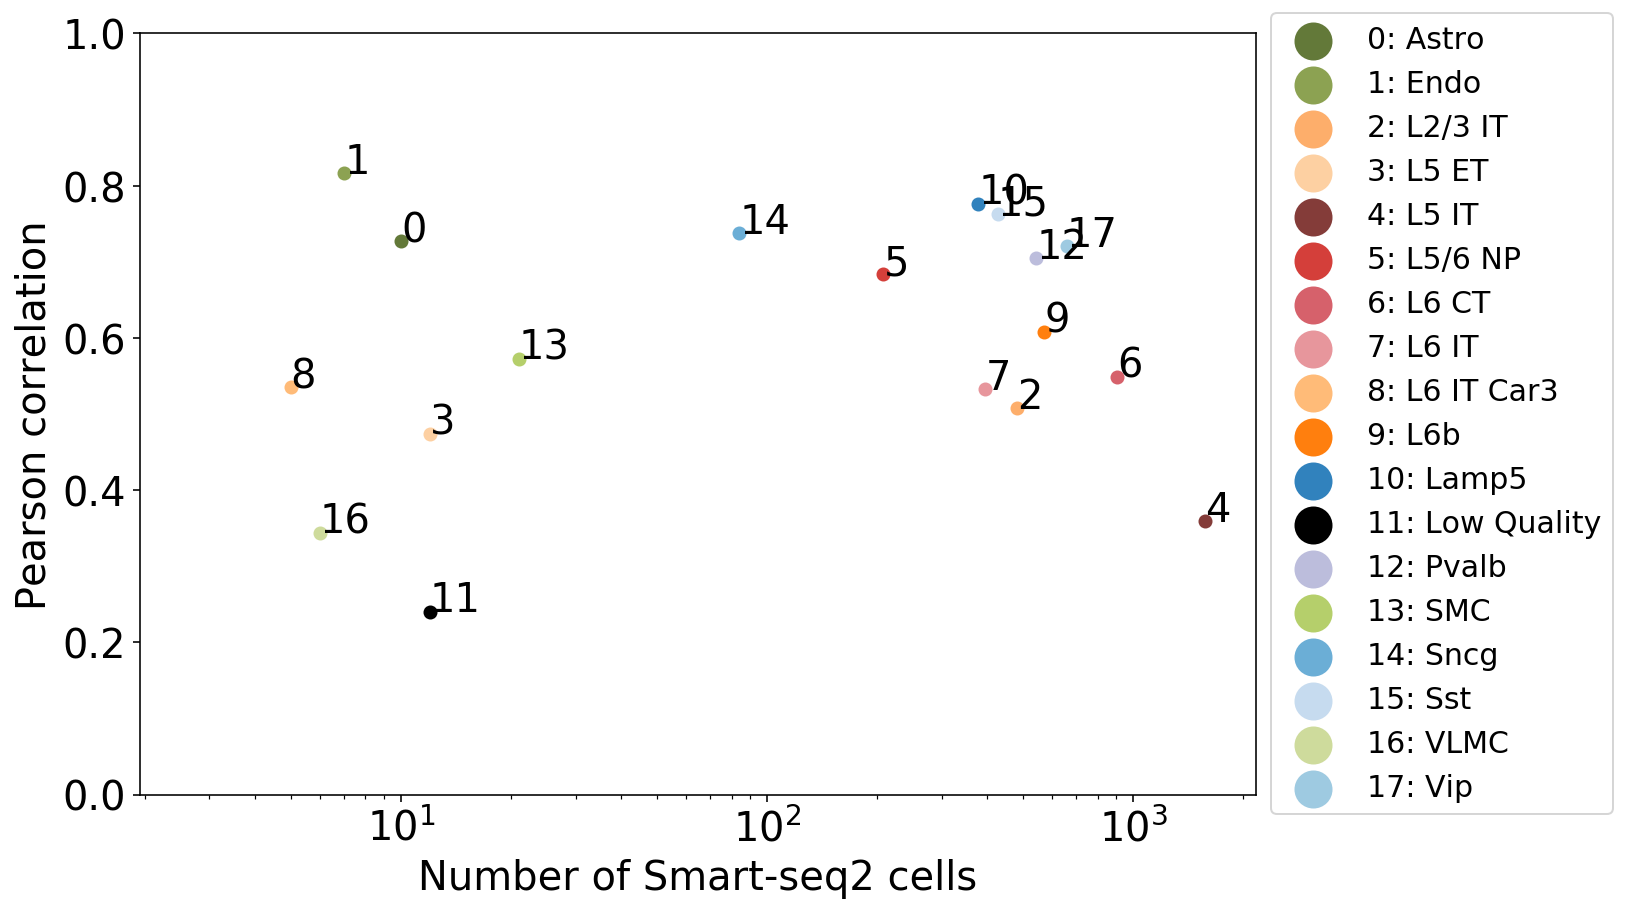

In [39]:
fig, ax = plt.subplots(figsize=(10,7))

x = ss_size
y = r2

for i, txt in enumerate(unique):
    ax.annotate(i, (x[i], y[i]))
    ax.scatter(x[i], y[i], label="{}: {}".format(i, txt), color=cluster_cmap[txt])
ax.set_ylim((0, 1))
ax.set_xscale("log")
    
ax.set_xlabel("Number of Smart-seq2 cells")
ax.set_ylabel("Pearson correlation")
ax.legend(fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5), markerscale=3)
plt.savefig("./figures/10x_subclass_isoform_correlation.png", bbox_inches='tight', dpi=300)
plt.show()

In [40]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

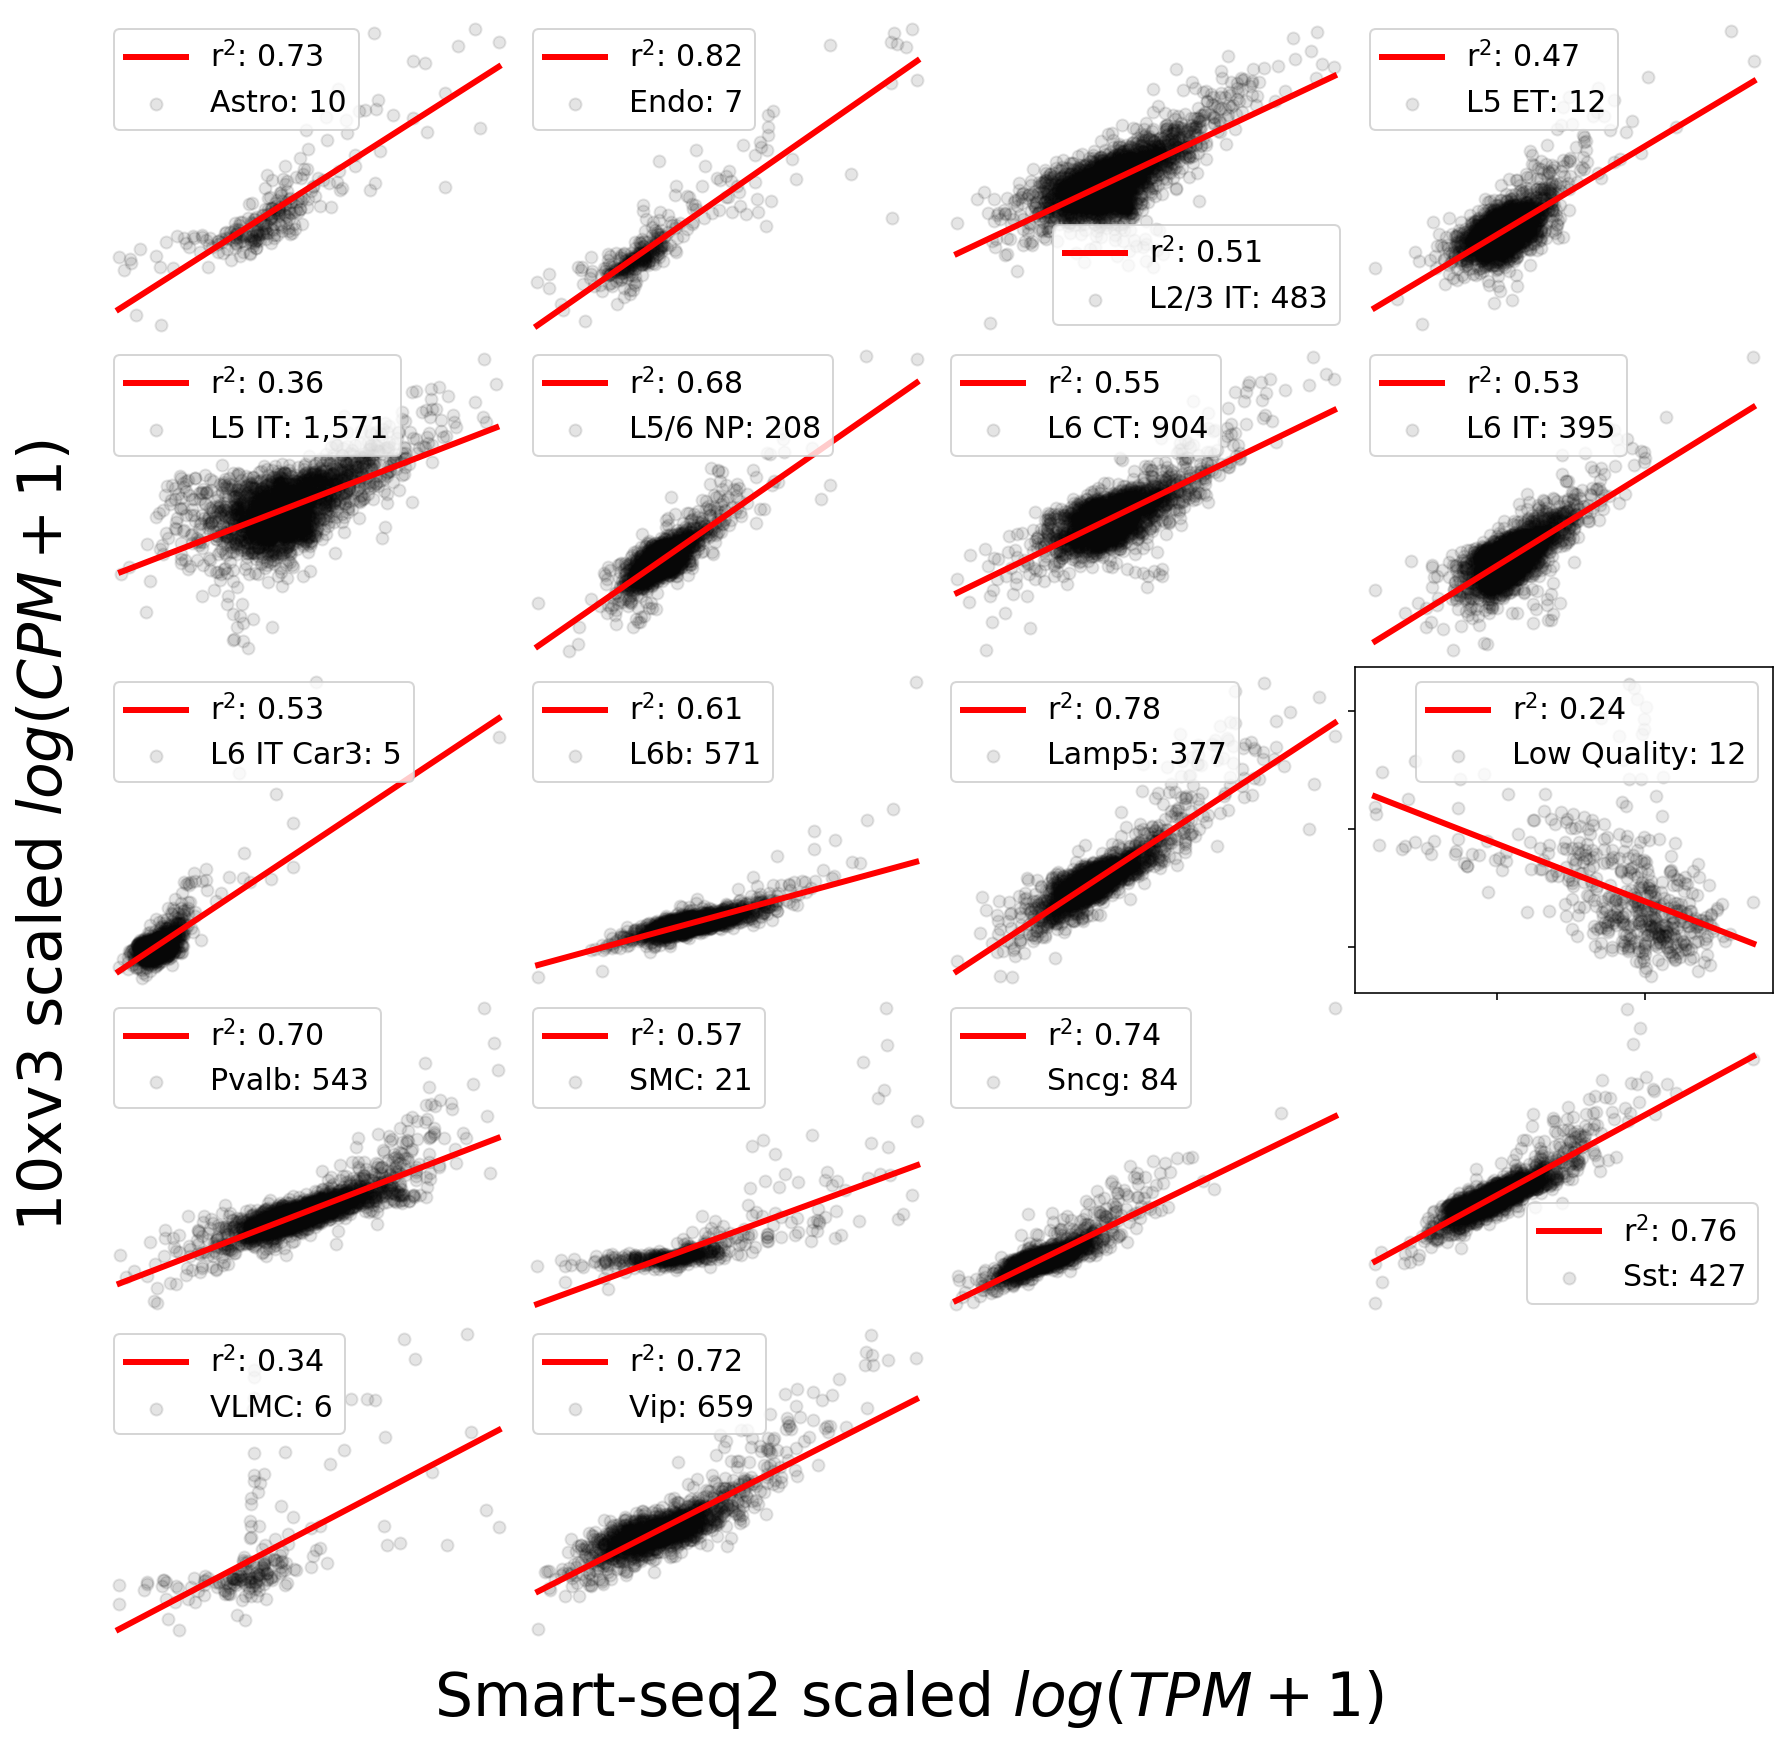

In [41]:
fig, ax = plt.subplots(figsize=(15,15), ncols=4, nrows=5)
fig.subplots_adjust(hspace=0, wspace=0)
axs = trim_axs(ax, len(unique))

for cidx, (ax, c) in enumerate(zip(axs, unique)):
    
    
    x = ss_x[cidx]
    y = tenx_x[cidx]

    
    ax.scatter(x, y, label="{}: {:,}".format(c, ss_size[cidx]), color="k", alpha=0.1)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    minx = min(x)
    maxx = max(x)
    x = np.linspace(minx, maxx, 10)
    y = slope*x+intercept
    ax.plot(x, y, label="r$^2$: {:,.2f}".format(r_value**2), color="red", linewidth=3)
    ax.legend(fontsize=15)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_axis_off()
    if c == "Low Quality":
        ax.set_axis_on()
fig.text(0.5, 0.1, 'Smart-seq2 scaled $log(TPM+1)$', ha='center', va='center', fontsize=30)
fig.text(0.1, 0.5, '10xv3 scaled $log(CPM+1)$', ha='center', va='center', rotation='vertical', fontsize=30)
plt.savefig("./figures/10x_subclass_isoform_correlation_scatter.png", bbox_inches='tight',dpi=300)

plt.show()

# Correlation at cluster level

In [42]:
tenx_mat = tenx.X
tenx_ass = tenx.obs.cluster_label.values

In [43]:
ss_mat = ss.X
ss_ass = ss.obs.cluster_label.values

In [44]:
features = tenx.var.transcript_name.values

unique = np.intersect1d(np.unique(tenx_ass), np.unique(ss_ass))

In [45]:
def nd(arr):
    return np.asarray(arr).reshape(-1)

In [46]:
mat = tenx.layers["log1p"]

lower = 0.5


bool_mask = np.zeros((unique.shape[0], features.shape[0]), dtype=bool)

for uidx, u in enumerate(unique):
    t_mat, _ = split_by_target(mat, tenx_ass, u)

    numc = t_mat.shape[0]
    numnz = (t_mat>0).sum(axis=0)

    #arr = np.logical_and(nd(numnz>lower*numc), nd(numnz<upper*numc))
    arr = nd(numnz>lower*numc)
    
    #arr = np.logical_and(np.array(t_mat.mean(axis=0)>threshold).reshape(-1), (np.array((t_mat>0).sum(axis=0)>t_mat.shape[0]*frac).reshape(-1)))
    print("[{} of {}] {:,}: {}".format(uidx+1, unique.shape[0],arr.sum(), u) )
    
    #argnmax = arr.argsort()[-n:][::-1]

    bool_mask[uidx,:][arr] = True

[1 of 22] 253: Astro Aqp4
[2 of 22] 3,455: L5 IT Pld5
[3 of 22] 3,366: L5 IT Tcap_1
[4 of 22] 2,517: L5 IT Tcap_2
[5 of 22] 2,908: L6 CT Gpr139
[6 of 22] 3,155: L6 IT Car3
[7 of 22] 3,474: L6b Rprm
[8 of 22] 3,022: L6b Shisa6
[9 of 22] 2,495: Lamp5 Lhx6
[10 of 22] 3,917: Pvalb Calb1
[11 of 22] 3,337: Pvalb Reln
[12 of 22] 3,262: Pvalb Vipr2
[13 of 22] 2,993: Sst Chodl
[14 of 22] 3,716: Sst Crhr2_1
[15 of 22] 3,589: Sst Crhr2_2
[16 of 22] 2,482: Sst Myh8_1
[17 of 22] 2,770: Sst Myh8_2
[18 of 22] 1,820: Vip C1ql1
[19 of 22] 1,575: Vip Crispld2
[20 of 22] 2,174: Vip Gpc3
[21 of 22] 1,450: Vip Igfbp6
[22 of 22] 1,860: Vip Serpinf1


In [47]:
%%time
r2 = []
ss_x = []
tenx_x = []

# u_mat_tenx = []
# u_mat_ss   = []

for uidx, u in enumerate(unique):
    tenx_t_mat, _ = split_by_target(tenx_mat, tenx_ass, u)
    ss_t_mat, _ = split_by_target(ss_mat, ss_ass, u)
    
    # u_mat_tenx.append(tenx_t_mat)
    # u_mat_ss.append(ss_t_mat)
    
    
    t = np.asarray(tenx_t_mat[:,bool_mask[uidx]].mean(axis=0)).reshape(-1)
    s = np.asarray(ss_t_mat[:,bool_mask[uidx]].mean(axis=0)).reshape(-1)
    
    ss_x.append(s)
    tenx_x.append(t)
    
    r, p = stats.pearsonr(t, s)
    r2.append(r**2)
    print("[{} of {}] {:,.2f}: {}".format(uidx+1, unique.shape[0],r**2, u) )

[1 of 22] 0.73: Astro Aqp4
[2 of 22] 0.13: L5 IT Pld5
[3 of 22] 0.33: L5 IT Tcap_1
[4 of 22] 0.19: L5 IT Tcap_2
[5 of 22] 0.63: L6 CT Gpr139
[6 of 22] 0.53: L6 IT Car3
[7 of 22] 0.44: L6b Rprm
[8 of 22] 0.48: L6b Shisa6
[9 of 22] 0.58: Lamp5 Lhx6
[10 of 22] 0.64: Pvalb Calb1
[11 of 22] 0.69: Pvalb Reln
[12 of 22] 0.59: Pvalb Vipr2
[13 of 22] 0.76: Sst Chodl
[14 of 22] 0.57: Sst Crhr2_1
[15 of 22] 0.57: Sst Crhr2_2
[16 of 22] 0.72: Sst Myh8_1
[17 of 22] 0.67: Sst Myh8_2
[18 of 22] 0.68: Vip C1ql1
[19 of 22] 0.75: Vip Crispld2
[20 of 22] 0.69: Vip Gpc3
[21 of 22] 0.66: Vip Igfbp6
[22 of 22] 0.48: Vip Serpinf1
CPU times: user 4min 7s, sys: 7min 45s, total: 11min 52s
Wall time: 11min 52s


In [48]:
ss_size = ss.obs["cluster_label"].value_counts()[unique]

In [49]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 ET" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

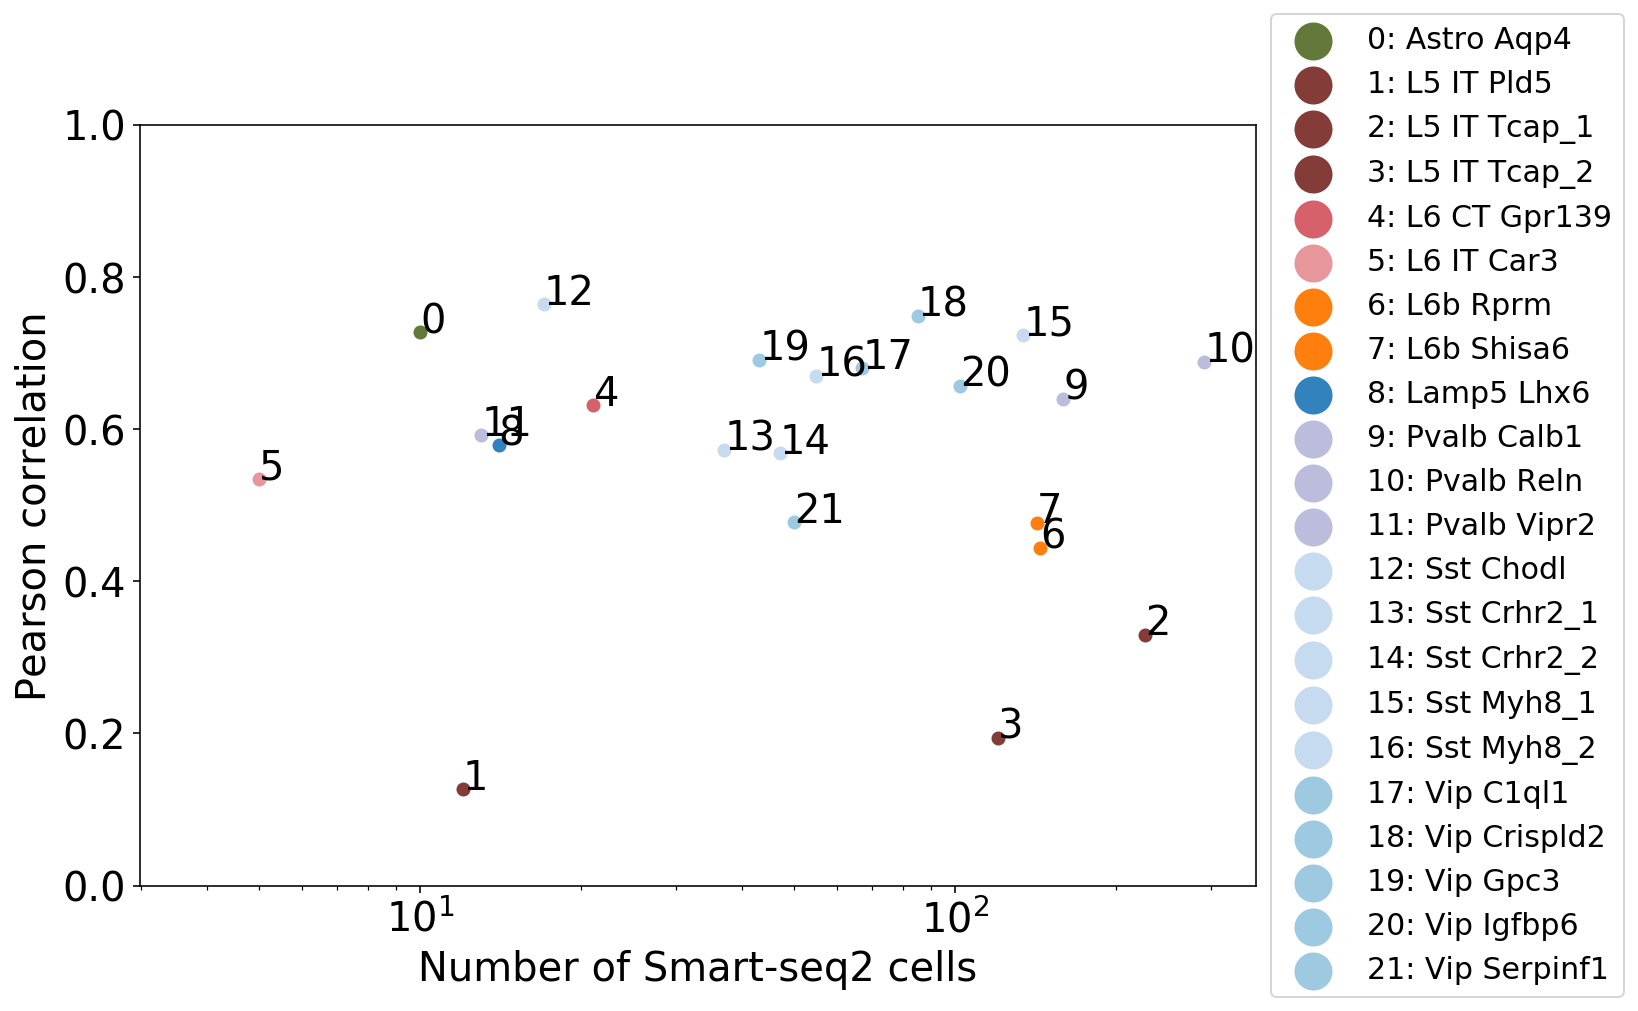

In [50]:
fig, ax = plt.subplots(figsize=(10,7))

x = ss_size
y = r2

for i, txt in enumerate(unique):
    ax.annotate(i, (x[i], y[i]))
    ax.scatter(x[i], y[i], label="{}: {}".format(i, txt),color=cluster_cmap[" ".join(txt.split(" ")[0:-1])])
ax.set_ylim((0, 1))
ax.set_xscale("log")
    
ax.set_xlabel("Number of Smart-seq2 cells")
ax.set_ylabel("Pearson correlation")
ax.legend(fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5), markerscale=3)
plt.savefig("./figures/10x_cluster_isoform_correlation_.png", bbox_inches='tight', dpi=300)
plt.show()

In [51]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

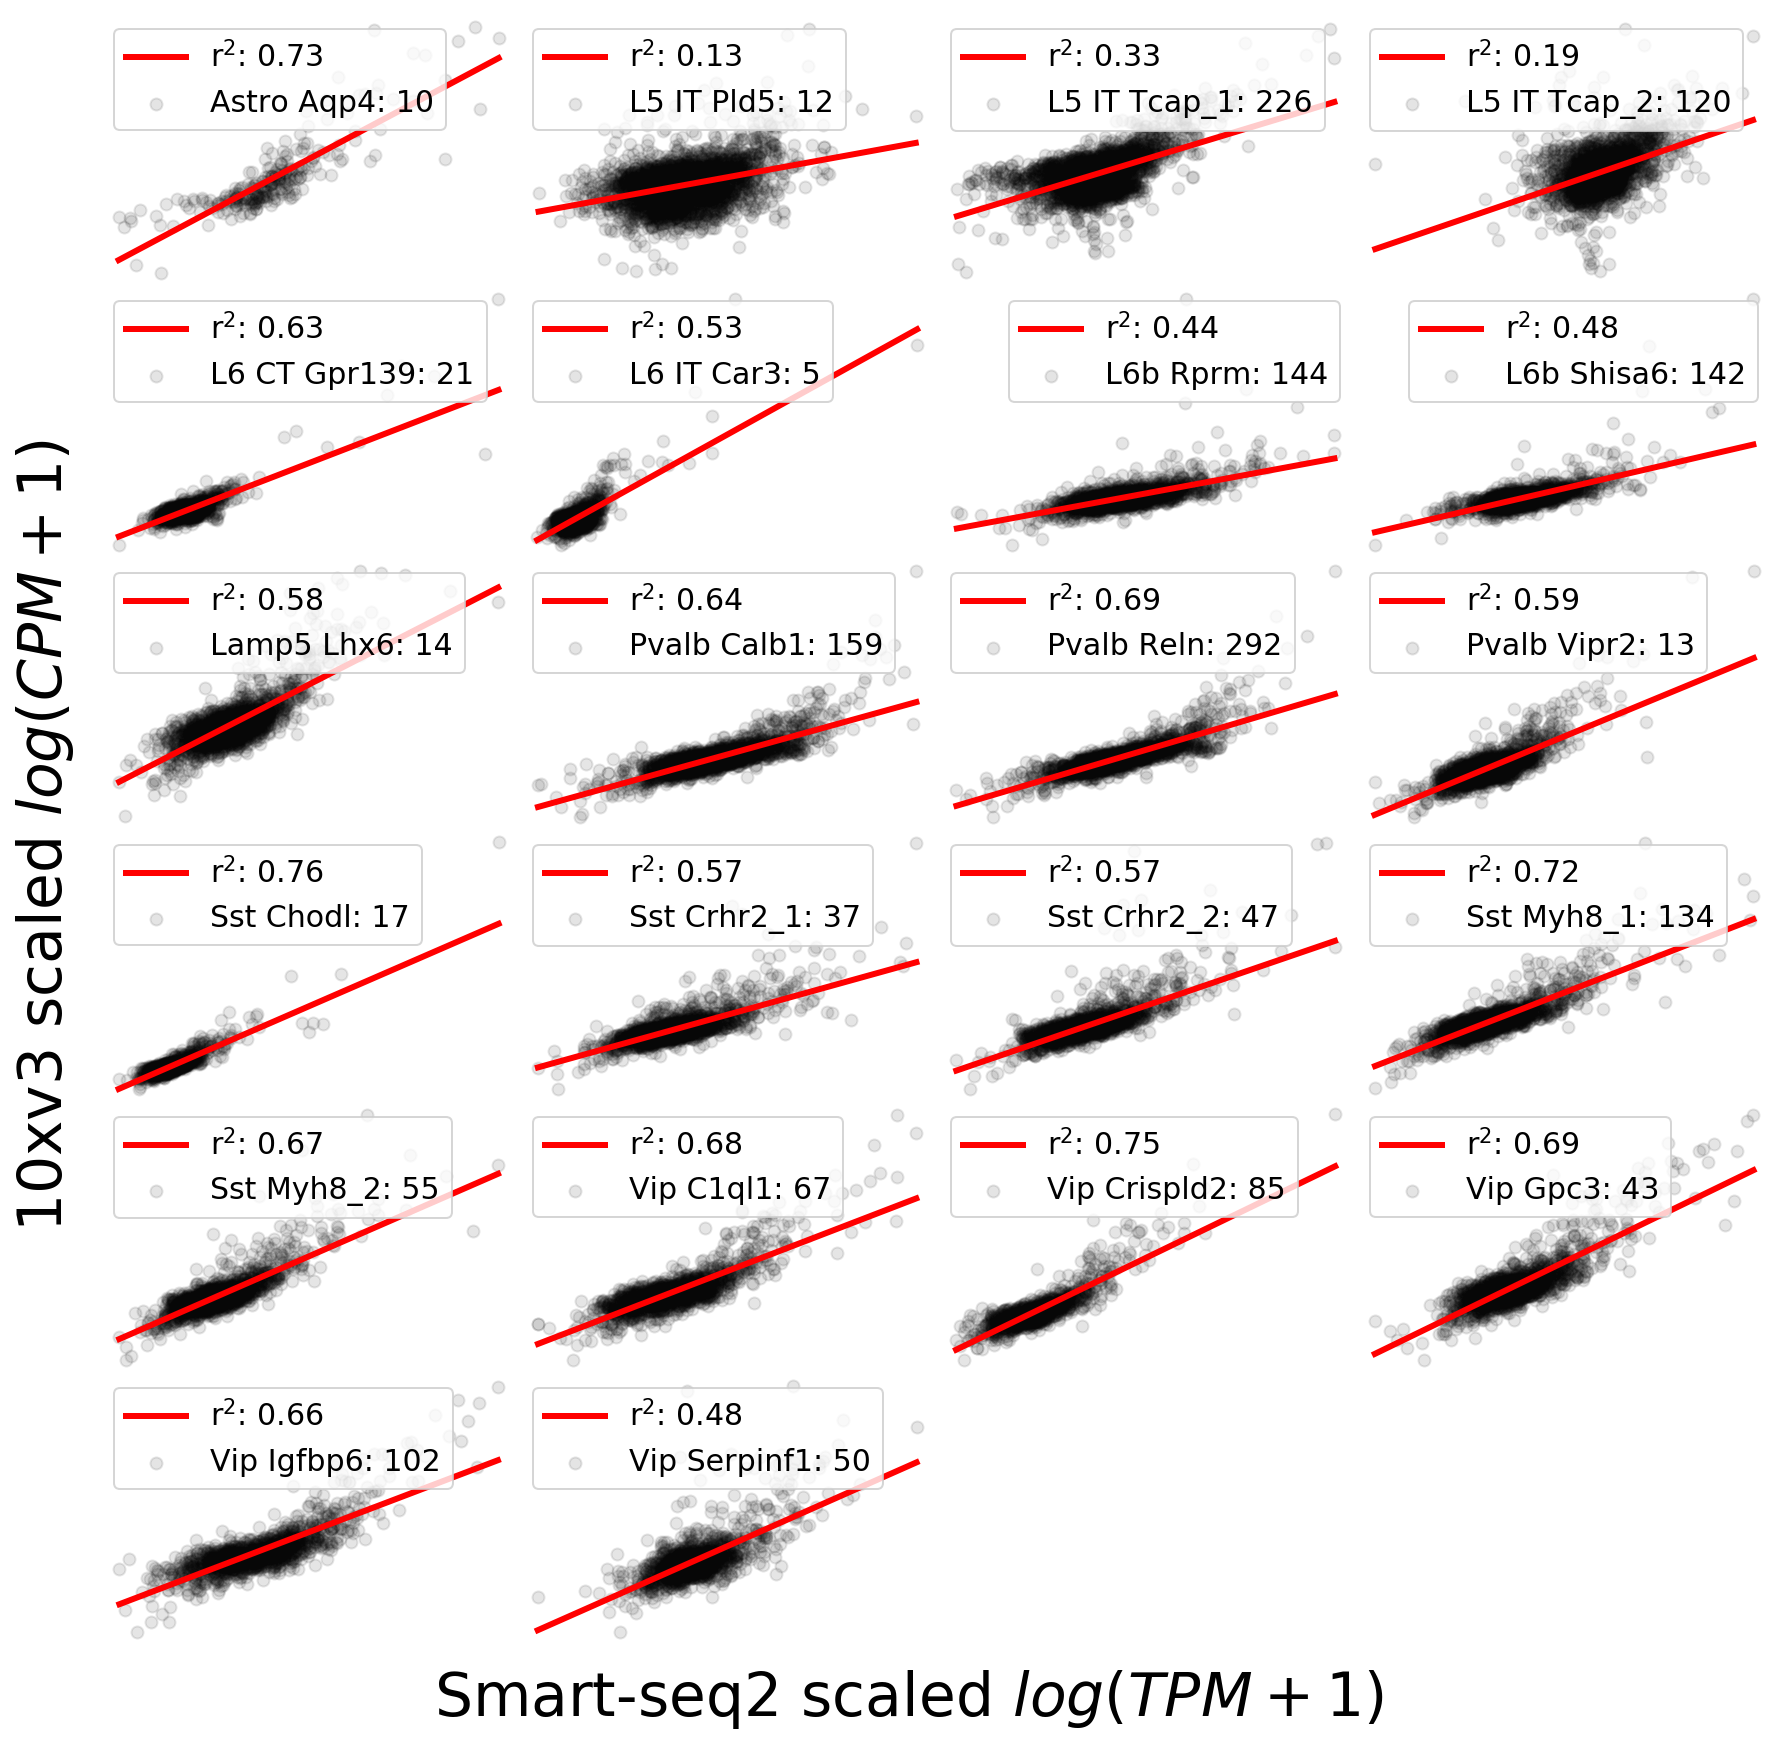

In [52]:
fig, ax = plt.subplots(figsize=(15,15), ncols=4, nrows=6)
fig.subplots_adjust(hspace=0, wspace=0)
axs = trim_axs(ax, len(unique))

for cidx, (ax, c) in enumerate(zip(axs, unique)):
    
    
    x = ss_x[cidx]
    y = tenx_x[cidx]

    
    ax.scatter(x, y, label="{}: {:,}".format(c, ss_size[cidx]), color="k", alpha=0.1)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    minx = min(x)
    maxx = max(x)
    x = np.linspace(minx, maxx, 10)
    y = slope*x+intercept
    ax.plot(x, y, label="r$^2$: {:,.2f}".format(r_value**2), color="red", linewidth=3)
    ax.legend(fontsize=15)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_axis_off()
    if c == "Low Quality":
        ax.set_axis_on()
fig.text(0.5, 0.1, 'Smart-seq2 scaled $log(TPM+1)$', ha='center', va='center', fontsize=30)
fig.text(0.1, 0.5, '10xv3 scaled $log(CPM+1)$', ha='center', va='center', rotation='vertical', fontsize=30)
plt.savefig("./figures/10x_cluster_isoform_correlation_scatter.png", bbox_inches='tight',dpi=300)

plt.show()